In [2]:
import sys, os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm

from src.data_loader import load_cookie_cats

/Users/stolero.ofek/Library/Mobile Documents/com~apple~CloudDocs/Files/Projects/Repos/cookiecats-abtest-analytics/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
df = load_cookie_cats()
df.head(10)

Dataset path: /Users/stolero.ofek/.cache/kagglehub/datasets/yufengsui/mobile-games-ab-testing/versions/1


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False


In [6]:
# Count retained users (successes) and total users by version
summary = df.groupby("version")['retention_7'].agg(['sum','count'])
summary.columns = ['retained','total']
summary['rate'] = summary['retained'] / summary['total']
summary

,retained,total,rate
version,,,
gate_30,8502,44700,0.190201
gate_40,8279,45489,0.182000


In [7]:
# Extract numbers
success_30 = summary.loc['gate_30','retained']
total_30   = summary.loc['gate_30','total']
success_40 = summary.loc['gate_40','retained']
total_40   = summary.loc['gate_40','total']

# Sample proportions
p1 = success_30 / total_30
p2 = success_40 / total_40

# Pooled proportion
p = (success_30 + success_40) / (total_30 + total_40)

# Standard error
se = np.sqrt(p * (1 - p) * (1/total_30 + 1/total_40))

# Z-score
z = (p1 - p2) / se

# Two-tailed p-value
pval = 2 * (1 - stats.norm.cdf(abs(z)))

print(f"D7 retention gate_30: {p1:.3%}")
print(f"D7 retention gate_40: {p2:.3%}")
print(f"Difference: {(p1-p2):.3%}")
print(f"z = {z:.2f}, p-value = {pval:.4f}")


D7 retention gate_30: 19.020%
D7 retention gate_40: 18.200%
Difference: 0.820%
z = 3.16, p-value = 0.0016


In [8]:
def cohen_h(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

h = cohen_h(p1, p2)
print(f"Cohen's h = {h:.3f}")

Cohen's h = 0.021


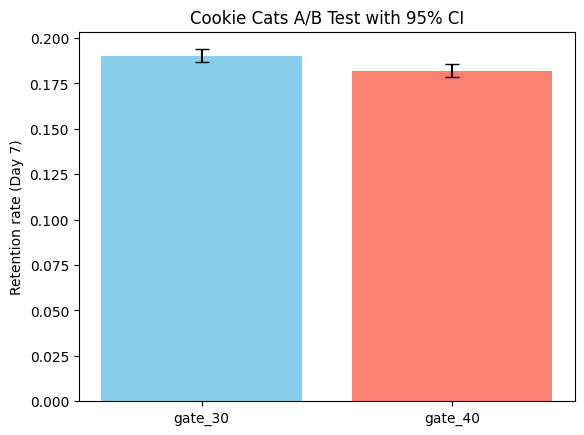

 gate_30: (0.19020134228187918, (0.18656311652199903, 0.19383956804175934)) 
 gate_40: (0.18200004396667327, (0.17845430073314686, 0.18554578720019968))


In [14]:
conf_30 = sm.stats.proportion_confint(success_30, total_30, alpha=0.05, method='normal')
conf_40 = sm.stats.proportion_confint(success_40, total_40, alpha=0.05, method='normal')

plt.bar(["gate_30","gate_40"], [p1, p2], yerr=[
    [p1 - conf_30[0], p2 - conf_40[0]],  # lower
    [conf_30[1] - p1, conf_40[1] - p2]   # upper
], capsize=5, color=["skyblue","salmon"])

plt.ylabel("Retention rate (Day 7)")
plt.title("Cookie Cats A/B Test with 95% CI")
plt.show()

print(f" gate_30: ({p1}, {conf_30})", '\n', f"gate_40: ({p2}, {conf_40})")


# Setup:
#### Compared Day 7 retention between gate_30 and gate_40 groups.
#### Each group had ~45k players.
# Results:
#### Gate 30 retention: 19.0%
#### Gate 40 retention: 18.2%
#### Difference: +0.8 percentage points
# Statistical test:
#### Two-proportion z-test: z = 3.16, p = 0.0016
#### Result is statistically significant (p < 0.05).
#### Effect size is very small (Cohen’s h = 0.021).
# Visualization:
#### Bar chart with 95% confidence intervals confirms the difference is real, but the margin is narrow.
# Conclusion:
#### Moving the gate from level 30 to 40 reduces Day 7 retention slightly.
#### The effect is statistically significant but practically small.
#### Recommendation: Keep the gate at level 30 to maximize long-term player retention.